In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extraccion, transformacion y carga (ETL)

In [3]:
import pandas as pd
import numpy as np
import json
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

In [4]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [7]:
# Desactivar la notación científica
pd.set_option('display.float_format', '{:.2f}'.format)  # Mostrar 2 decimales

Primer mirada a uno de los archivos json.

In [8]:
# Cargar los datos JSON, manejando posibles errores de decodificación
data = []
with open('/content/drive/MyDrive/Datasets_PF/Google Maps/reviews-estados/review-California/1.json', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data.append(json.loads(line)) # Cargar cada línea como un objeto JSON
        except json.JSONDecodeError as e:
            print(f"Error al decodificar JSON: {e}")

# Si los datos se cargaron correctamente, crear el DataFrame
if data:
    df = pd.DataFrame(data)
else:
    print("No se encontraron datos válidos en el archivo.")

In [9]:
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,108991152262655788985,Song Ro,1609909927056,5,Love there korean rice cake.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
1,111290322219796215751,Rafa Robles,1612849648663,5,Good very good,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
2,112640357449611959087,David Han,1583643882296,4,They make Korean traditional food very properly.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
3,117440349723823658676,Anthony Kim,1551938216355,5,Short ribs are very delicious.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49
4,100580770836123539210,Mario Marzouk,1494910901933,5,Great food and prices the portions are large,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49


Creamos una funcion para unir todos los archivos json que tenemos por estado

In [10]:
def crear_df(ruta):
    """
    Crea un DataFrame a partir de todos los archivos JSON en una carpeta.

    Args:
        ruta_carpeta (str): Ruta a la carpeta que contiene los archivos JSON.

    Returns:
        pandas.DataFrame: DataFrame concatenado con los datos de todos los archivos JSON,
                           o None si no se encontraron datos válidos.
    """

    dataframes  = []

    for archivo in glob.glob(ruta + '/*.json'):
        data = []
        with open(archivo, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    item = json.loads(line)
                    # Normalizar 'pics':
                    if 'pics' in item:
                        item['pics_url'] = item['pics'][0]['url'][0] if item['pics'] else None
                    # Normalizar 'resp':
                    if 'resp' in item:
                        item['resp_time'] = item['resp']['time'] if item['resp'] else None
                        item['resp_text'] = item['resp']['text'] if item['resp'] else None
                    data.append(item)
                except json.JSONDecodeError as e:
                    print(f"Error al decodificar JSON en el archivo {archivo}: {e}")

        if data:
            df = pd.DataFrame(data)
            dataframes.append(df)

    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    else:
        return None

In [11]:
df_california = crear_df('/content/drive/MyDrive/Datasets_PF/Google Maps/reviews-estados/review-California')

In [12]:
df_whashington = crear_df('/content/drive/MyDrive/Datasets_PF/Google Maps/reviews-estados/review-Washington')

In [13]:
df_california.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,pics_url,resp_time,resp_text
0,108991152262655788985,Song Ro,1609909927056,5,Love there korean rice cake.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,NaN,None
1,111290322219796215751,Rafa Robles,1612849648663,5,Good very good,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,NaN,None
2,112640357449611959087,David Han,1583643882296,4,They make Korean traditional food very properly.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,NaN,None
3,117440349723823658676,Anthony Kim,1551938216355,5,Short ribs are very delicious.,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,NaN,None
4,100580770836123539210,Mario Marzouk,1494910901933,5,Great food and prices the portions are large,None,None,0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,NaN,None


In [14]:
df_california.shape

(2700000, 11)

In [15]:
df_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700000 entries, 0 to 2699999
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   name       object 
 2   time       int64  
 3   rating     int64  
 4   text       object 
 5   pics       object 
 6   resp       object 
 7   gmap_id    object 
 8   pics_url   object 
 9   resp_time  float64
 10  resp_text  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 226.6+ MB


In [16]:
df_whashington.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,pics_url,resp_time,resp_text
0,103093043835388050629,Casper Steele,1626907411534,2,Drivers say security has bathroom key. Securit...,None,None,0x5495ae7d3bf7d097:0xbcbc06152a3ccebc,None,NaN,None
1,111014066796803341223,Judy Maes,1613028426989,5,It's a CTRAN transit center with schedules to ...,None,None,0x5495ae7d3bf7d097:0xbcbc06152a3ccebc,None,NaN,None
2,111724423355988809570,Daniel Hernandez,1536710665852,5,Neat little Transit Center with lots of schedu...,None,None,0x5495ae7d3bf7d097:0xbcbc06152a3ccebc,None,NaN,None
3,115331094085411087904,Lumi Nosa,1484359806540,5,Very helpful. Thanks,None,None,0x5495ae7d3bf7d097:0xbcbc06152a3ccebc,None,NaN,None
4,106906383883851362879,James Conright,1500643741079,1,They don't sell tacos.,None,None,0x5495ae7d3bf7d097:0xbcbc06152a3ccebc,None,NaN,None


In [17]:
df_whashington.shape

(1942020, 11)

In [18]:
df_whashington.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942020 entries, 0 to 1942019
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   name       object 
 2   time       int64  
 3   rating     int64  
 4   text       object 
 5   pics       object 
 6   resp       object 
 7   gmap_id    object 
 8   pics_url   object 
 9   resp_time  float64
 10  resp_text  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 163.0+ MB


Ejemplo de los registros de un usuario en particular

In [19]:
df_california[df_california['user_id'] == '106713404097592788958']

,user_id,name,time,rating,text,pics,resp,gmap_id,pics_url,resp_time,resp_text
30,106713404097592788958,Matt Schapiro,1609790121449,5,"Easy process, extremely friendly, helpful staf...",None,"{'time': 1631072651706, 'text': 'Thanks so muc...",0x80960c29f2e3bf29:0x4b291f0d275a5699,None,1631072651706.00,Thanks so much for your business and for takin...
13973,106713404097592788958,Matt Schapiro,1609790121449,5,"Easy process, extremely friendly, helpful staf...",None,"{'time': 1631072651706, 'text': 'Thanks so muc...",0x80960c29f2e3bf29:0x4b291f0d275a5699,None,1631072651706.00,Thanks so much for your business and for takin...
135383,106713404097592788958,Matt Schapiro,1611958690529,5,"Excellent, quick, and easy service.",None,None,0x80960e82e109a7b3:0x7196e4b5b09aa630,None,NaN,None


Eliminar las columnas originales 'pics' y 'resp' ya que los datos anidados ya se encuentran normalizados en columnas individuales.

In [20]:
columnas_a_eliminar = ['pics', 'resp']
df_california = df_california.drop(columns=columnas_a_eliminar, axis=1)
df_whashington = df_whashington.drop(columns=columnas_a_eliminar, axis=1)

Valores Nulos

In [21]:
df_california.isnull().sum()  # Identifica columnas con valores nulos

,0
user_id,0
name,0
time,0
rating,0
text,1170964
gmap_id,0
pics_url,2600710
resp_time,2454831
resp_text,2454831


In [22]:
df_whashington.isnull().sum()

,0
user_id,0
name,0
time,0
rating,0
text,794099
gmap_id,0
pics_url,1867160
resp_time,1718196
resp_text,1718196


La mayor parte de los valores faltantes o nulos se encuentran en la respuesta a la reseña, esto puede significar que son muy pocos los propietarios que leen y comentan las reseñas de su local.
Por otra parte, un gran numero de usuarios, entre un 40% y un 45%, registra el puntaje del comercio pero no dejan comentarios.

Valores duplicados

In [23]:
df_california.duplicated().sum()

75242

In [24]:
df_whashington.duplicated().sum()

35590

In [25]:
df_california.drop_duplicates(inplace=True)
df_whashington.drop_duplicates(inplace=True)

En ambos dataframes hay valores duplicados que luego fueron eliminados (entre un 2% y un3% del total de registros)

# Analisis Exploratorio de Datos (EDA)

## Analisis de las respuestas a las reseñas.

In [26]:
# Contar el número total de respuestas (filas no nulas en la columna 'resp_text')
total_respuestas = df_california['resp_text'].count()

print(f"En el estado de California, {total_respuestas} comentarios tienen respuestas.")

En el estado de California, 238457 comentarios tienen respuestas.


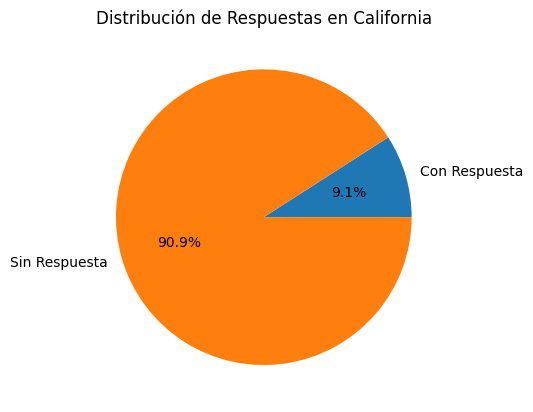

In [27]:
sin_respuesta = len(df_california) - total_respuestas

# Crear el gráfico de torta
plt.pie([total_respuestas, sin_respuesta], labels=['Con Respuesta', 'Sin Respuesta'], autopct='%1.1f%%')
plt.title('Distribución de Respuestas en California')
plt.show()

In [28]:
# Contar el número total de respuestas (filas no nulas en la columna 'resp_text')
total_respuestas2 = df_whashington['resp_text'].count()

print(f"En el estado de Washington, {total_respuestas2} comentarios tienen respuestas.")

En el estado de Washington, 219943 comentarios tienen respuestas.


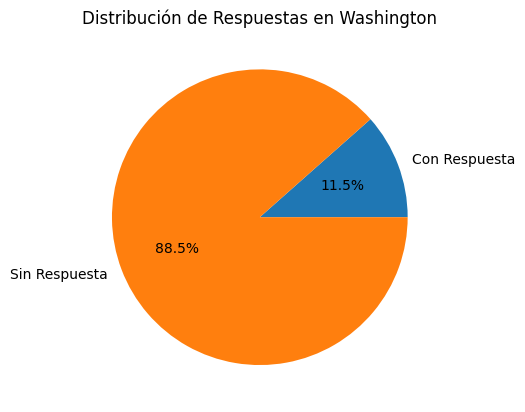

In [29]:
sin_respuesta2 = len(df_whashington) - total_respuestas2

# Crear el gráfico de torta
plt.pie([total_respuestas2, sin_respuesta2], labels=['Con Respuesta', 'Sin Respuesta'], autopct='%1.1f%%')
plt.title('Distribución de Respuestas en Washington')
plt.show()

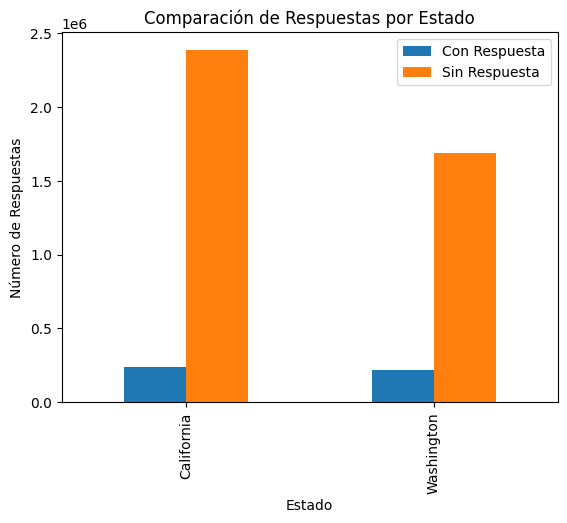

In [30]:
data = {'Estado': ['California', 'Washington'],
        'Con Respuesta': [total_respuestas, total_respuestas2],
        'Sin Respuesta': [sin_respuesta, sin_respuesta2]}
df = pd.DataFrame(data)

# Crear el gráfico de barras
df.plot(x='Estado', kind='bar')
plt.title('Comparación de Respuestas por Estado')
plt.xlabel('Estado')
plt.ylabel('Número de Respuestas')
plt.show()

## Analisis de las valoraciones

In [31]:
df_california.describe()

,time,rating,resp_time
count,2624758.00,2624758.00,238457.00
mean,1551618625086.32,4.31,1570671181904.77
std,46463458911.18,1.12,38074422085.69
min,662601600000.00,1.00,1298310895300.00
25%,1523132247396.75,4.00,1547151488898.00
50%,1555369074104.50,5.00,1573227974193.00
75%,1582401479984.00,5.00,1602621520331.00
max,1631149232337.00,5.00,1631130273148.00


In [32]:
df_california['rating'].value_counts(normalize=True)

,proportion
rating,
5,0.63
4,0.19
3,0.09
1,0.06
2,0.03


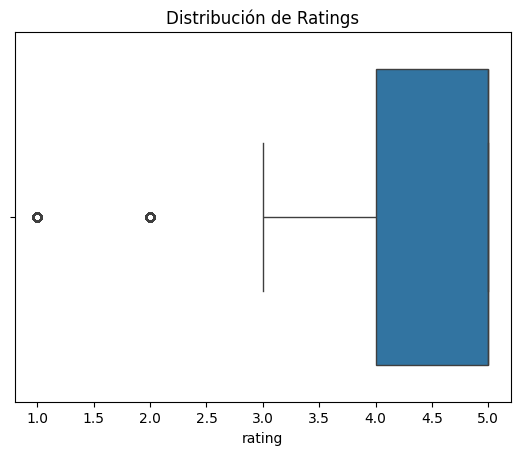

In [33]:
sns.boxplot(x='rating', data=df_california)
plt.title('Distribución de Ratings')
plt.show()

In [34]:
df_whashington.describe()

,time,rating,resp_time
count,1906430.00,1906430.00,219943.00
mean,1551108480732.31,4.34,1568255713928.49
std,43469532375.40,1.09,36822114960.90
min,1077148800000.00,1.00,1299692498823.00
25%,1524330836590.00,4.00,1545164094281.00
50%,1554589063115.00,5.00,1570240843525.00
75%,1580248081738.50,5.00,1599177610766.50
max,1631177670011.00,5.00,1631050754032.00


In [35]:
df_whashington['rating'].value_counts(normalize=True)

,proportion
rating,
5,0.64
4,0.20
3,0.08
1,0.05
2,0.03


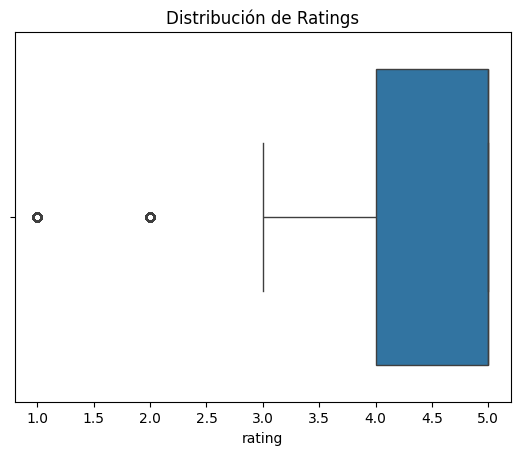

In [36]:
sns.boxplot(x='rating', data=df_whashington)
plt.title('Distribución de Ratings')
plt.show()

Los datos en ambos dataframe sugieren que la mayoría de los usuarios están muy satisfechos con lo que están calificando, ya sea un producto, servicio o contenido. La distribución sesgada a la derecha podría indicar que los usuarios más satisfechos son más propensos a dejar una calificación. Sin embargo, existe una pequeña proporción de usuarios que otorgaron calificaciones muy bajas; estos outliers podrían indicar problemas específicos que necesitan ser abordados para mejorar la satisfacción del cliente.

*   Mayoría de ratings altos: La caja y la mediana se encuentran cercanas al valor máximo de 5.0, lo que indica que la mayoría de los ratings otorgados son altos.
*   Pocos ratings bajos: Los valores atípicos (outliers) se encuentran en la parte inferior del gráfico, cerca de 1.0 y 2.0, sugiriendo que hay una pequeña cantidad de ratings muy bajos.
*   Pocas variaciones en el rango intercuartílico (IQR): La caja es relativamente pequeña, lo que implica que el 50% de los datos (entre el primer y tercer cuartil) están agrupados en un rango estrecho, cerca del valor máximo.
*   Distribución sesgada a la derecha: La mediana está más cerca del límite superior de la caja que del inferior, lo que indica una ligera asimetría positiva o sesgo a la derecha. Esto significa que hay más observaciones en la cola derecha de la distribución (valores más altos).

Analisis de sentimiento con VADER

In [37]:
# Inicializar el analizador de sentimiento VADER
sia = SentimentIntensityAnalyzer()

def analizar_sentimiento(text):
    if pd.isna(text) or not text.strip():  # Verifica si el texto está vacío o es solo espacios en blanco
        return None
    else:
        return sia.polarity_scores(text)['compound']

In [38]:
# Aplicar la función a la columna 'text'
df_california['SIA'] = df_california['text'].apply(analizar_sentimiento)

In [39]:
df_whashington['SIA'] = df_whashington['text'].apply(analizar_sentimiento)

In [40]:
# Calcular la polaridad promedio
polaridad_promedio = df_california['SIA'].mean()
print("Polaridad promedio:", polaridad_promedio)

Polaridad promedio: 0.4988814913736755


In [41]:
polaridad_promedio_w = df_whashington['SIA'].mean()
print("Polaridad promedio:", polaridad_promedio_w)

Polaridad promedio: 0.5384060080205072


Contar los textos positivos, negativos y neutrales

In [42]:
# Crear una nueva serie con etiquetas de sentimiento
sentimientos = pd.cut(df_california['SIA'], bins=[-np.inf, 0, np.inf], labels=['negativo', 'positivo'])

# Contar los sentimientos (agrupa los valores de la nueva serie y cuenta las ocurrencias de cada grupo)
conteo_sentimientos = sentimientos.groupby(sentimientos, observed=False).size()
porcentaje_sentimientos = conteo_sentimientos / conteo_sentimientos.sum() * 100

print(conteo_sentimientos)
print(porcentaje_sentimientos)

SIA
negativo     298329
positivo    1162606
Name: SIA, dtype: int64
SIA
negativo   20.42
positivo   79.58
Name: SIA, dtype: float64


In [43]:
# Crear una nueva serie con etiquetas de sentimiento
sentimientos_w = pd.cut(df_whashington['SIA'], bins=[-np.inf, 0, np.inf], labels=['negativo', 'positivo'])

# Contar los sentimientos (agrupa los valores de la nueva serie y cuenta las ocurrencias de cada grupo)
conteo_sentimientos_w = sentimientos_w.groupby(sentimientos_w, observed=False).size()
porcentaje_sentimientos_w = conteo_sentimientos_w / conteo_sentimientos_w.sum() * 100

print(conteo_sentimientos_w)
print(porcentaje_sentimientos_w)

SIA
negativo    197299
positivo    916845
Name: SIA, dtype: int64
SIA
negativo   17.71
positivo   82.29
Name: SIA, dtype: float64


## Analisis de las reseñas

Preprocesar el texto:

*  Convertir a minúsculas: Para agrupar palabras con diferentes mayúsculas.
*  Eliminar stop words: Palabras comunes como "el", "la", "los", "las", que aportan poco significado al análisis.
*  Tokenizar: Dividir el texto en palabras individuales.
*  Eliminar puntuación: Quitar signos de puntuación que no aportan información.

In [44]:
stop_words = set(stopwords.words('english'))

# Ejemplo de preprocesamiento básico
def preprocess_text(text):
    if text is not None:
        words = word_tokenize(text.lower())
        words = [word for word in words if word not in stop_words]
        words = [re.sub(r'[^\w\s]', '', word) for word in words]  # Elimina signos de puntuación
        return " ".join(words)
    else:
        return ""  # Devolver una cadena vacía para valores None

In [45]:
df_california['texto_procesado'] = df_california['text'].apply(preprocess_text)

In [46]:
df_whashington['texto_procesado'] = df_whashington['text'].apply(preprocess_text)

In [47]:
# Crear una cadena con todas las palabras
all_words = ' '.join(df_california['texto_procesado'])

In [48]:
all_words_w = ' '.join(df_whashington['texto_procesado'])

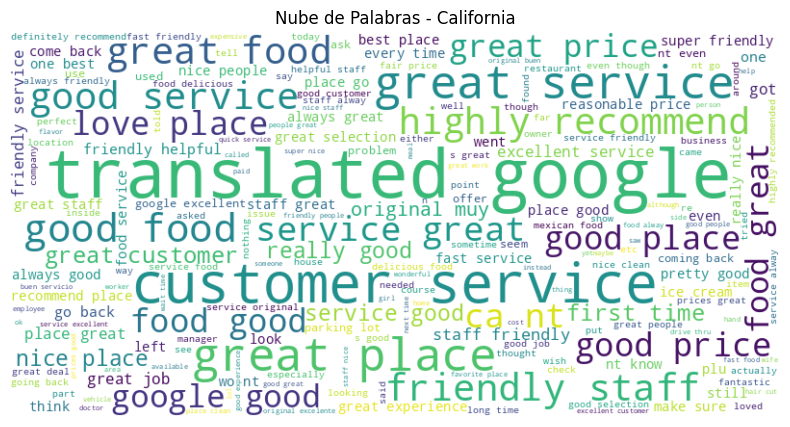

In [49]:
# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nube de Palabras - California')

plt.show()

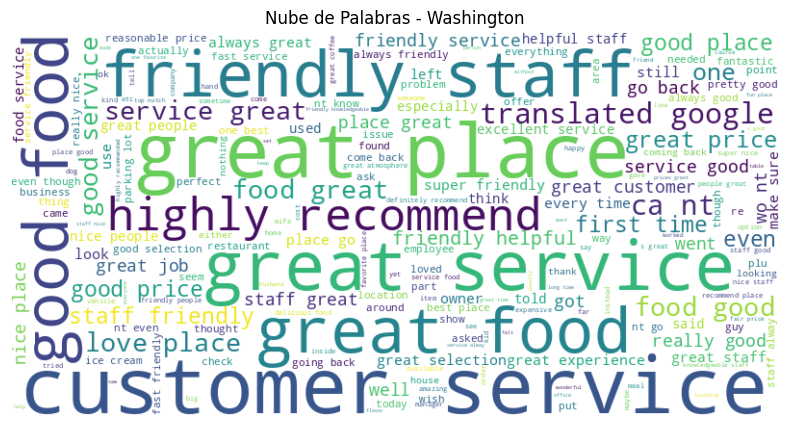

In [50]:
# Generar la nube de palabras
wordcloud_w = WordCloud(width=800, height=400, background_color='white').generate(all_words_w)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_w, interpolation='bilinear')
plt.axis("off")
plt.title('Nube de Palabras - Washington')

plt.show()

Crear una lista de las palabras mas frecuentes

In [51]:
# Contar las palabras
word_counts = Counter(all_words.split()) # crea un diccionario donde las claves son las palabras y los valores son sus frecuencias.

# Convertir a DataFrame
word_freq_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['frecuencia'])

# Ordenar las filas por la columna 'frecuencia' en orden descendente.
word_freq_df = word_freq_df.sort_values('frecuencia', ascending=False)

Crear un gráfico de barras para visualizar las frecuencias de las palabras más frecuentes.

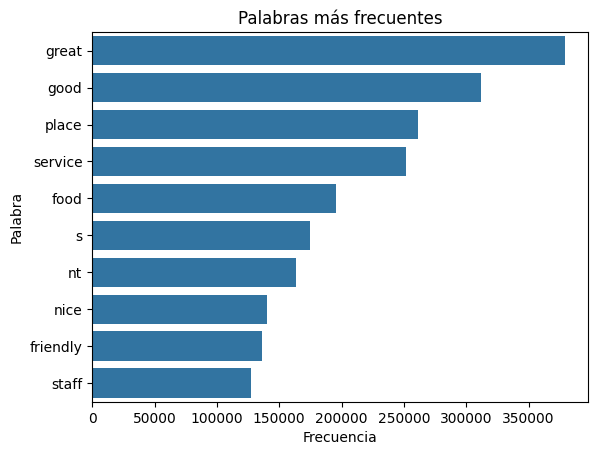

In [52]:
sns.barplot(x='frecuencia', y=word_freq_df.index[:10], data=word_freq_df.head(10))
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras más frecuentes')
plt.show()

In [53]:
import seaborn as sns

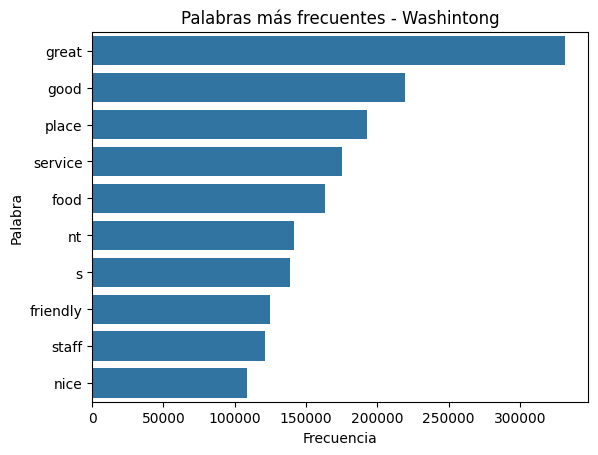

In [54]:
# Contar las palabras
word_counts_w = Counter(all_words_w.split()) # crea un diccionario donde las claves son las palabras y los valores son sus frecuencias.

# Convertir a DataFrame
word_freq_df_w = pd.DataFrame.from_dict(word_counts_w, orient='index', columns=['frecuencia'])

# Ordenar las filas por la columna 'frecuencia' en orden descendente.
word_freq_df_w = word_freq_df_w.sort_values('frecuencia', ascending=False)

sns.barplot(x='frecuencia', y=word_freq_df_w.index[:10], data=word_freq_df_w.head(10))
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras más frecuentes - Washintong')
plt.show()

Análisis de Co-ocurrencia: Identificando Palabras que Van Juntas

Esto es útil para identificar temas, relaciones entre conceptos y patrones lingüísticos. Por ejemplo, en un análisis de reseñas de películas, podríamos descubrir que las palabras "acción" y "excitante" suelen co-ocurrir.

In [55]:
# Crear una función para contar co-ocurrencias en todo el corpus
def co_occurrencia_matriz(tokens, window_size):
    coocurrencia_matriz = Counter()
    for sentence in tokens:
        for pair in ngrams(sentence, window_size):
            coocurrencia_matriz[pair] += 1
    return coocurrencia_matriz

In [56]:
# Crear la matriz de co-ocurrencia directamente desde la columna 'texto_procesado'
tokens = df_california['texto_procesado'].str.split()  # Dividir cada fila en listas de palabras
coocurrencia_matriz = co_occurrencia_matriz(tokens, 2)  # Ajusta el tamaño de la ventana si es necesario

# Convertir la matriz de Counter a un DataFrame para facilitar el análisis
df_cooccurrences = pd.DataFrame.from_dict(coocurrencia_matriz, orient='index', columns=['count'])

# Visualización o análisis posterior (ej: filtrar por las co-ocurrencias más frecuentes)
top_coocurrencias = df_cooccurrences.sort_values('count', ascending=False).head(20)
top_coocurrencias

,count
"(translated, google)",87541
"(customer, service)",54793
"(great, place)",36458
"(great, service)",36045
"(good, food)",25041
"(friendly, staff)",22623
"(good, service)",22337
"(great, food)",22313
"(highly, recommend)",21715
"(ca, nt)",18538


In [57]:
# Crear la matriz de co-ocurrencia directamente desde la columna 'texto_procesado'
tokens_w = df_whashington['texto_procesado'].str.split()  # Dividir cada fila en listas de palabras
coocurrencia_matriz_w = co_occurrencia_matriz(tokens_w, 2)  # Ajusta el tamaño de la ventana si es necesario

# Convertir la matriz de Counter a un DataFrame para facilitar el análisis
df_cooccurrences_w = pd.DataFrame.from_dict(coocurrencia_matriz_w, orient='index', columns=['count'])

# Visualización o análisis posterior (ej: filtrar por las co-ocurrencias más frecuentes)
top_coocurrencias_w = df_cooccurrences_w.sort_values('count', ascending=False).head(20)
top_coocurrencias_w

,count
"(customer, service)",35492
"(great, place)",32566
"(great, service)",26609
"(friendly, staff)",22643
"(great, food)",22078
"(good, food)",21495
"(highly, recommend)",17952
"(translated, google)",17445
"(ca, nt)",16707
"(love, place)",13870


En base a estas co-ocurrencias encontradas podemos deducir que lo mas valorado por los usuarios es el servicio, el lugar, la comida y si el personal es amable, algo que iria de la mano con la calidad del servicio brindado.